Episode 0, Total Reward: 107.72716131153956, Epsilon: 0.995
Episode 100, Total Reward: 102.23448436184806, Epsilon: 0.6027415843082742
Episode 200, Total Reward: 147.52991240630217, Epsilon: 0.36512303261753626
Episode 300, Total Reward: 87.50328799094298, Epsilon: 0.2211807388415433
Episode 400, Total Reward: -115.44088123293295, Epsilon: 0.13398475271138335
Episode 500, Total Reward: 151.84638723773452, Epsilon: 0.0811640021330769
Episode 600, Total Reward: 132.5238551043778, Epsilon: 0.04916675299948831
Episode 700, Total Reward: 138.42774870055692, Epsilon: 0.029783765425331846
Episode 800, Total Reward: 138.13338551303403, Epsilon: 0.018042124582040707
Episode 900, Total Reward: 18.88852463200944, Epsilon: 0.010929385683282892


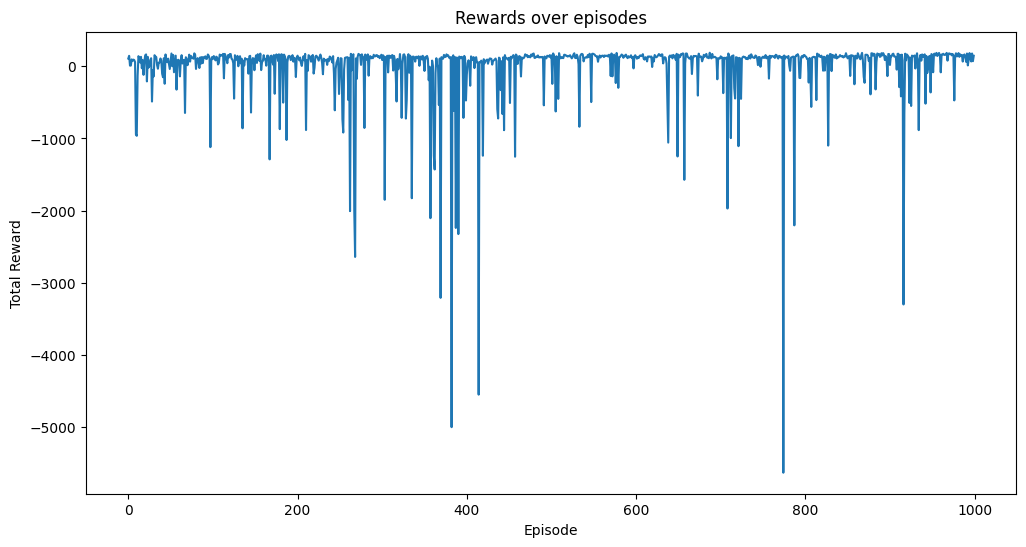

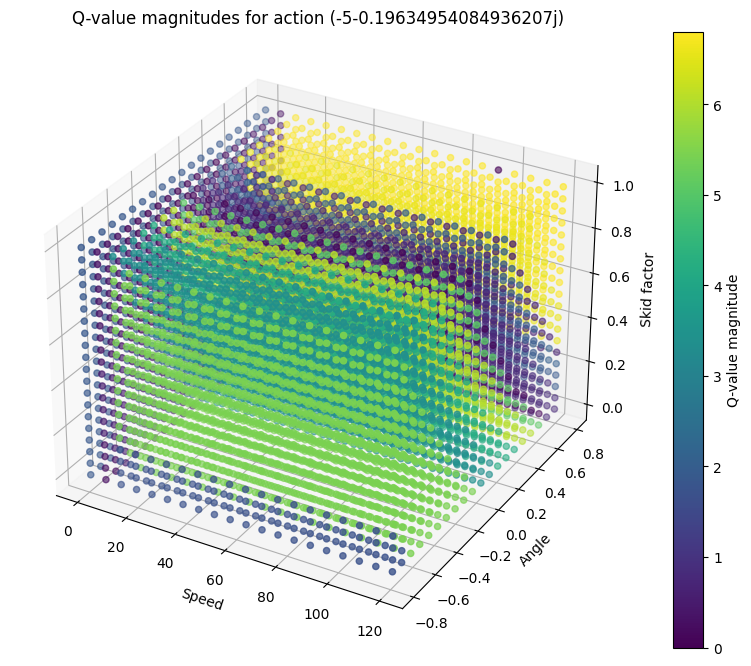

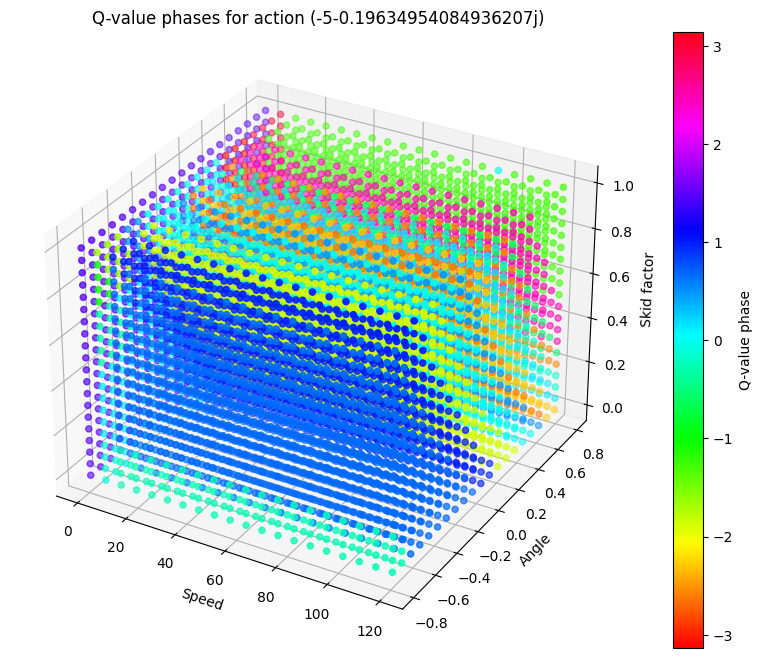

Phase coherence for state (74.4931041649024+6.534900013012098j): 0.6911384803566282


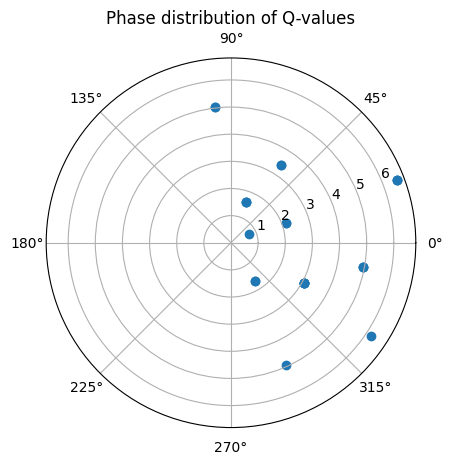

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

class ComplexEnvironment:
    def __init__(self):
        # Initialize the environment with max speed, max steering angle, and road conditions
        self.max_speed = 120  # Maximum speed of the vehicle
        self.max_angle = np.pi/4  # Maximum steering angle (45 degrees)
        self.road_conditions = ['dry', 'wet', 'icy']  # Possible road conditions
        self.reset()  # Reset the environment to its initial state

    def reset(self):
        # Reset the environment to a random initial state
        self.speed = np.random.uniform(30, 90)  # Initial speed is randomly set between 30 and 90
        self.angle = np.random.uniform(-np.pi/8, np.pi/8)  # Initial angle is randomly set between -22.5 and 22.5 degrees
        self.road_condition = np.random.choice(self.road_conditions)  # Randomly select road condition
        return self.get_complex_state()  # Return the complex state representation

    def get_complex_state(self):
        # Determine the skid factor based on the road condition
        if self.road_condition == 'dry':
            skid_factor = np.random.uniform(0, 0.1)  # Low skid on dry roads
        elif self.road_condition == 'wet':
            skid_factor = np.random.uniform(0.1, 0.5)  # Moderate skid on wet roads
        else:  # icy
            skid_factor = np.random.uniform(0.5, 1.0)  # High skid on icy roads

        # Represent the state as a complex number
        return complex(self.speed * np.cos(self.angle), self.speed * np.sin(self.angle)) * (1 + 1j * skid_factor)

    def step(self, action):
        # Action is now a complex number, where the real part is speed change and the imaginary part is angle change
        self.speed += action.real  # Update speed
        self.angle += action.imag  # Update angle

        # Constrain the values to their limits
        self.speed = np.clip(self.speed, 0, self.max_speed)  # Speed should not exceed max speed
        self.angle = np.clip(self.angle, -self.max_angle, self.max_angle)  # Angle should be within limits

        # Calculate reward for the current step
        reward = self.calculate_reward()  # Call reward calculation method

        return self.get_complex_state(), reward  # Return the new state and reward

    def calculate_reward(self):
        # Calculate the reward based on the current state
        state = self.get_complex_state()  # Get the current complex state
        speed = np.abs(state)  # Get the speed from the magnitude of the complex state
        angle = np.angle(state)  # Get the angle from the argument of the complex state
        real_part = np.real(state)  # Extract the real part (speed component)
        imag_part = np.imag(state)  # Extract the imaginary part (skid component)

        # Determine skid factor based on the real part
        if abs(real_part) < 1e-5:
            skid_factor = 0  # If real part is close to zero, set skid factor to zero
        else:
            skid_factor = imag_part / real_part  # Calculate skid factor

        # Optimal speed and steering angle rewards
        speed_reward = 1 - abs(speed - 60) / 60  # Normalize reward based on optimal speed of 60
        angle_reward = 1 - abs(angle) / (np.pi/4)  # Normalize reward based on optimal angle
        skid_penalty = -skid_factor  # Apply penalty for skid

        total_reward = speed_reward + angle_reward + skid_penalty  # Total reward calculation

        return total_reward  # Return the calculated total reward

class ComplexQLearning:
    def __init__(self, state_dim, action_dim, learning_rate=0.1, discount_factor=0.9):
        # Initialize Q-learning agent with state dimensions, action dimensions, learning rate, and discount factor
        self.state_dim = state_dim  # Dimensions of the state space
        self.action_dim = action_dim  # Dimensions of the action space
        self.learning_rate = learning_rate  # Learning rate for Q-value updates
        self.discount_factor = discount_factor  # Discount factor for future rewards
        self.q_table = np.zeros(state_dim + action_dim, dtype=complex)  # Initialize Q-table with complex values
        self.R_t = complex(1, 0)  # Initial value of R_t (phase reference)

    def phase_function(self, t, road_condition):
        # A more complex phase function that accounts for the road condition (skid affects phase)
        if road_condition == 'dry':
            return np.exp(1j * (np.pi/6 * t + np.sin(t/10)))  # Phase function for dry conditions
        elif road_condition == 'wet':
            return np.exp(1j * (np.pi/4 * t + np.sin(t/8)))  # Phase function for wet conditions
        else:  # icy
            return np.exp(1j * (np.pi/3 * t + np.sin(t/6)))  # Phase function for icy conditions

    def get_q_value(self, state, action):
        # Get the Q-value for a specific state-action pair
        state_index = self.discretize_state(state)  # Discretize the state
        action_index = self.discretize_action(action)  # Discretize the action
        return self.q_table[state_index + action_index]  # Return the corresponding Q-value

    def set_q_value(self, state, action, value):
        # Set the Q-value for a specific state-action pair
        state_index = self.discretize_state(state)  # Discretize the state
        action_index = self.discretize_action(action)  # Discretize the action
        self.q_table[state_index + action_index] = value  # Update the Q-value

    def update_q_value(self, state, action, reward, next_state, t, road_condition):
        # Update the Q-value based on the Bellman equation
        current_q = self.get_q_value(state, action)  # Get the current Q-value
        next_max_q = max([self.get_q_value(next_state, a) for a in self.get_possible_actions()], key=lambda x: abs(x))  # Get max Q-value for next state

        # Incorporate phase information from the environment state and phase shift
        phase_adjustment = self.phase_function(t, road_condition)  # Get phase adjustment
        new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount_factor * next_max_q * phase_adjustment)  # Update Q-value
        self.set_q_value(state, action, new_q)  # Save the updated Q-value

    def choose_action(self, state, epsilon, t, road_condition):
        # Choose an action based on the epsilon-greedy strategy
        if random.uniform(0, 1) < epsilon:
            return random.choice(self.get_possible_actions())  # Choose a random action
        else:
            self.update_R_t(state, t, road_condition)  # Update the phase reference R_t
            # Phase coherence is used for action selection
            return max(self.get_possible_actions(), key=lambda a: np.real(self.get_q_value(state, a) * np.conj(self.R_t)))  # Choose action with highest phase coherence

    def update_R_t(self, state, t, road_condition):
        # Update R_t based on all possible actions and their phase coherence
        actions = self.get_possible_actions()  # Get all possible actions
        phase_values = [self.get_q_value(state, action) * self.phase_function(t, road_condition) for action in actions]  # Calculate phase values
        self.R_t = sum(phase_values) / len(phase_values)  # Update R_t to the average of phase values

    def get_possible_actions(self):
        # Generate possible actions as changes in speed and angle
        speed_changes = np.linspace(-5, 5, 5)  # Agent can increase or decrease speed
        angle_changes = np.linspace(-np.pi/16, np.pi/16, 5)  # Small changes in steering angle
        return [complex(s, a) for s in speed_changes for a in angle_changes]  # Return all combinations of speed and angle changes

    def discretize_state(self, state):
        # Discretize the continuous state into a finite state space
        magnitude = int(np.abs(state) / (self.state_dim[0] / 10))  # Magnitude is normalized
        angle = int((np.angle(state) + np.pi) / (2 * np.pi / self.state_dim[1]))  # Angle is normalized

        # Check for zero in the real part to avoid division errors
        if np.real(state) == 0:
            skid = 0  # Set skid to zero if the real part is zero
        else:
            skid = int((np.imag(state) / np.real(state)) * (self.state_dim[2] / 2))  # Calculate skid based on the ratio

        # Round indices to fit within valid bounds
        magnitude = max(0, min(magnitude, self.state_dim[0]-1))  # Ensure magnitude is within bounds
        angle = max(0, min(angle, self.state_dim[1]-1))  # Ensure angle is within bounds
        skid = max(0, min(skid, self.state_dim[2]-1))  # Ensure skid is within bounds

        return (magnitude, angle, skid)  # Return the discretized state index

    def discretize_action(self, action):
        # Calculate the change in speed based on the absolute value of the action
        speed_change = int(np.abs(action) / (self.action_dim[0] / 5))
        # Calculate the change in angle based on the angle of the action
        angle_change = int((np.angle(action) + np.pi/16) / (np.pi/8 / self.action_dim[1]))

        # Round the indices to fit within valid boundaries
        speed_change = max(0, min(speed_change, self.action_dim[0]-1))
        angle_change = max(0, min(angle_change, self.action_dim[1]-1))

        return (speed_change, angle_change)  # Return the discretized speed and angle changes





def train_agent(env, agent, episodes, max_steps, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995):
    rewards_history = []  # Store total rewards for each episode
    epsilon = epsilon_start  # Initialize exploration rate

    for episode in range(episodes):
        state = env.reset()  # Reset the environment for a new episode
        total_reward = 0  # Initialize total reward for the episode

        for t in range(max_steps):
            # Choose an action based on the current state and exploration rate
            action = agent.choose_action(state, epsilon, t, env.road_condition)
            # Step the environment and get the next state and reward
            next_state, reward = env.step(action)
            # Update the agent's Q-value based on the transition
            agent.update_q_value(state, action, reward, next_state, t, env.road_condition)
            state = next_state  # Move to the next state
            total_reward += reward  # Accumulate total reward

        rewards_history.append(total_reward)  # Record total reward for the episode
        # Decay the exploration rate to reduce exploration over time
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # Print progress every 100 episodes
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon}")

    return rewards_history  # Return the history of rewards


def visualize_q_values(agent):
    # Create a grid for visualization of Q-values
    speed = np.linspace(0, 120, 20)  # Speed range from 0 to 120
    angle = np.linspace(-np.pi/4, np.pi/4, 20)  # Angle range from -π/4 to π/4
    skid = np.linspace(0, 1, 20)  # Skid factor range from 0 to 1
    speed_grid, angle_grid, skid_grid = np.meshgrid(speed, angle, skid)  # Create a 3D grid

    # Choose one action to visualize its Q-values
    action = agent.get_possible_actions()[0]

    # Collect Q-values for the chosen action across the grid
    q_values = np.zeros_like(speed_grid, dtype=complex)  # Initialize Q-values array
    for i in range(speed_grid.shape[0]):
        for j in range(speed_grid.shape[1]):
            for k in range(speed_grid.shape[2]):
                # Construct the state from speed, angle, and skid factor
                state = complex(speed_grid[i, j, k] * np.cos(angle_grid[i, j, k]),
                                speed_grid[i, j, k] * np.sin(angle_grid[i, j, k])) * (1 + 1j * skid_grid[i, j, k])
                # Retrieve the Q-value for the constructed state and action
                q_values[i, j, k] = agent.get_q_value(state, action)

    # Visualize the magnitude of Q-values
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(speed_grid, angle_grid, skid_grid, c=np.abs(q_values), cmap='viridis')
    plt.colorbar(scatter, label='Q-value magnitude')  # Add color bar for magnitude
    ax.set_xlabel('Speed')
    ax.set_ylabel('Angle')
    ax.set_zlabel('Skid factor')
    plt.title(f'Q-value magnitudes for action {action}')
    plt.show()

    # Visualize the phase of Q-values
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(speed_grid, angle_grid, skid_grid, c=np.angle(q_values), cmap='hsv')
    plt.colorbar(scatter, label='Q-value phase')  # Add color bar for phase
    ax.set_xlabel('Speed')
    ax.set_ylabel('Angle')
    ax.set_zlabel('Skid factor')
    plt.title(f'Q-value phases for action {action}')
    plt.show()


def analyze_phase_coherence(agent, state):
    # Get all possible actions for the current state
    actions = agent.get_possible_actions()
    # Retrieve Q-values for each action
    q_values = [agent.get_q_value(state, action) for action in actions]
    phases = np.angle(q_values)  # Extract phases from Q-values

    # Calculate phase coherence
    mean_phase = np.mean(phases)  # Mean phase
    phase_coherence = np.abs(np.mean(np.exp(1j * (phases - mean_phase))))  # Coherence calculation

    print(f"Phase coherence for state {state}: {phase_coherence}")  # Output coherence value

    # Visualize phases on a polar plot
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    ax.scatter(phases, np.abs(q_values))  # Scatter plot of phases
    ax.set_title("Phase distribution of Q-values")  # Title for the plot
    plt.show()

# Main code execution
env = ComplexEnvironment()  # Create an instance of the complex environment
agent = ComplexQLearning(state_dim=(10, 10, 10), action_dim=(5, 5))  # Create an agent with state and action dimensions

# Training the agent
rewards = train_agent(env, agent, episodes=1000, max_steps=100)

# Visualizing the training results
plt.figure(figsize=(12, 6))
plt.plot(rewards)  # Plot rewards over episodes
plt.title('Rewards over episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Visualizing Q-values
visualize_q_values(agent)

# Analyzing phase coherence for an example state
example_state = env.reset()  # Reset environment to get an example state
analyze_phase_coherence(agent, example_state)  # Analyze phase coherence for that state
